# CITE-seq analysis

With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, integrate datasets, and compute differential expression of RNA and protein. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.

If you use totalVI, please consider citing:

* Gayoso, Adam, et al. "Joint probabilistic modeling of paired transcriptome and proteome measurements in single cells." bioRxiv (2020).



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi_tutorials/blob/master/totalVI.ipynb)

In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 112kB 9.2MB/s 
     |████████████████████████████████| 122kB 15.2MB/s 
     |████████████████████████████████| 8.7MB 12.7MB/s 
     |████████████████████████████████| 4.3MB 64.0MB/s 
     |████████████████████████████████| 153kB 62.1MB/s 
     |████████████████████████████████| 2.2MB 63.2MB/s 
     |████████████████████████████████| 2.4MB 52.4MB/s 
     |████████████████████████████████| 3.2MB 57.1MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 7.7MB 53.0MB/s 
     |████████████████████████████████| 952kB 67.4MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 92kB 13.3MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


## Imports and data loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.)

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO      Downloading file at data/pbmc_10k_protein_v3.h5ad                     
INFO      Downloading file at data/pbmc_5k_protein_v3.h5ad                      


In [4]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=4000, 
    flavor="seurat_v3",
    batch_key="batch", 
    subset=True,
    layer="counts"
)

In [5]:
scvi.data.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="batch", 
    protein_expression_obsm_key="protein_expression"
)

INFO      Using batches from adata.obs["batch"]                                 
INFO      No label_key inputted, assuming all cells have same label             
INFO      Using data from adata.layers["counts"]                                
INFO      Computing library size prior per batch                                
INFO      Using protein expression from adata.obsm['protein_expression']        
INFO      Using protein names from columns of adata.obsm['protein_expression']  
INFO      Successfully registered anndata object containing 10849 cells, 4000   
          genes, 2 batches, 1 labels, and 14 proteins. Also registered 0 extra  
          categorical covariates and 0 extra continuous covariates.             
INFO      Please do not further modify adata until model is trained.            


## Prepare and run model

Notice that the dataset has two batches in it. We input the number of batches to the totalVI model. If we would not like to perform batch correction, we can leave `n_batch = 0` when instantiating the `TOTALVI` model class -- which is also the default. Setting this parameter alerts totalVI to input the batch information in the encoder and decoder.

In [6]:
vae = scvi.model.TOTALVI(adata, use_cuda=True, latent_distribution="normal")

In [7]:
vae.train(lr=4e-3)

INFO      KL warmup for 400 epochs                                              


Output()

INFO      Training time:  510 s. / 400 epochs                                   


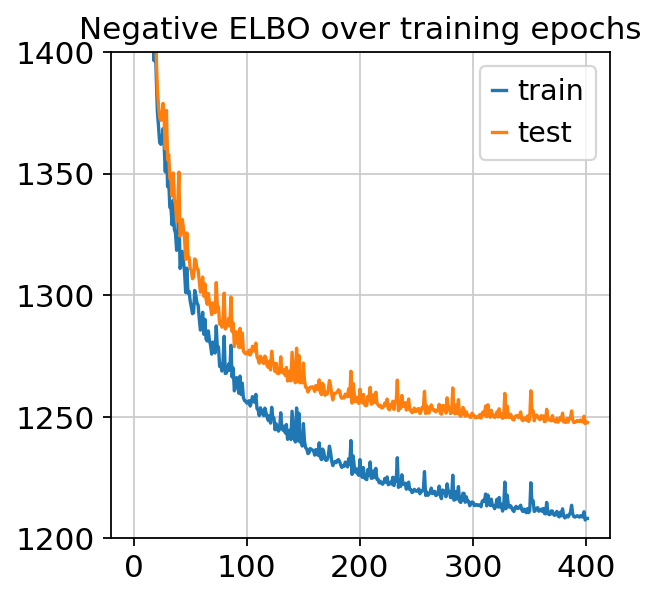

In [8]:
plt.plot(vae.trainer.history["elbo_train_set"], label="train")
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1200, 1400)
plt.legend()

## Analyze outputs

We use Scanpy for clustering and visualization after running totalVI. It's also possible to save totalVI outputs for an R-based workflow. First, we store the totalVI outputs in the appropriate slots in AnnData.

In [9]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25, 
    return_mean=True, 
    transform_batch=[0, 1]
)

adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25, 
    return_mean=True, 
    transform_batch=[0, 1]
)
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

Now we can compute clusters and visualize the latent space.

In [10]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

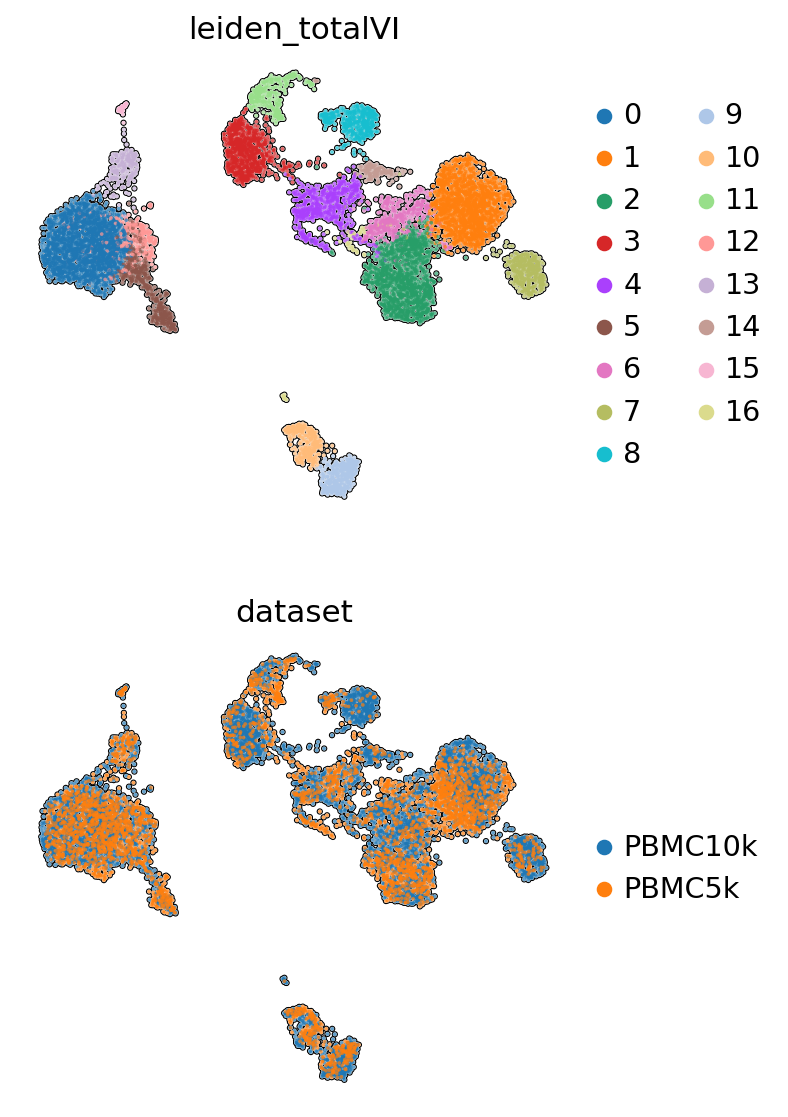

In [11]:
dataset_names = np.array(["PBMC10k", "PBMC5k"])
adata.obs["dataset"] = pd.Categorical(dataset_names[adata.obs.batch.ravel()])

sc.pl.umap(
    adata, 
    color=["leiden_totalVI", "dataset"], 
    frameon=False,
    ncols=1,
    add_outline=True
)

To visualize protein values on the umap, we make a temporary protein adata object. We have to copy over the umap from the original adata object.

In [12]:
pro_adata = sc.AnnData(adata.obsm["protein_expression"], obs=adata.obs)
sc.pp.log1p(pro_adata)
# Keep log normalized data in raw
pro_adata.raw = pro_adata
pro_adata.X = adata.obsm["denoised_protein"]
# these are cleaner protein names -- "_TotalSeqB" removed
pro_adata.var["protein_names"] = parsed_protein_names
pro_adata.obsm["X_umap"] = adata.obsm["X_umap"]
pro_adata.obsm["X_totalVI"] = adata.obsm["X_totalVI"]


In [13]:
names = adata.obsm["protein_foreground_prob"].columns
for p in names:
    pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p] 

### Visualize denoised protein values 

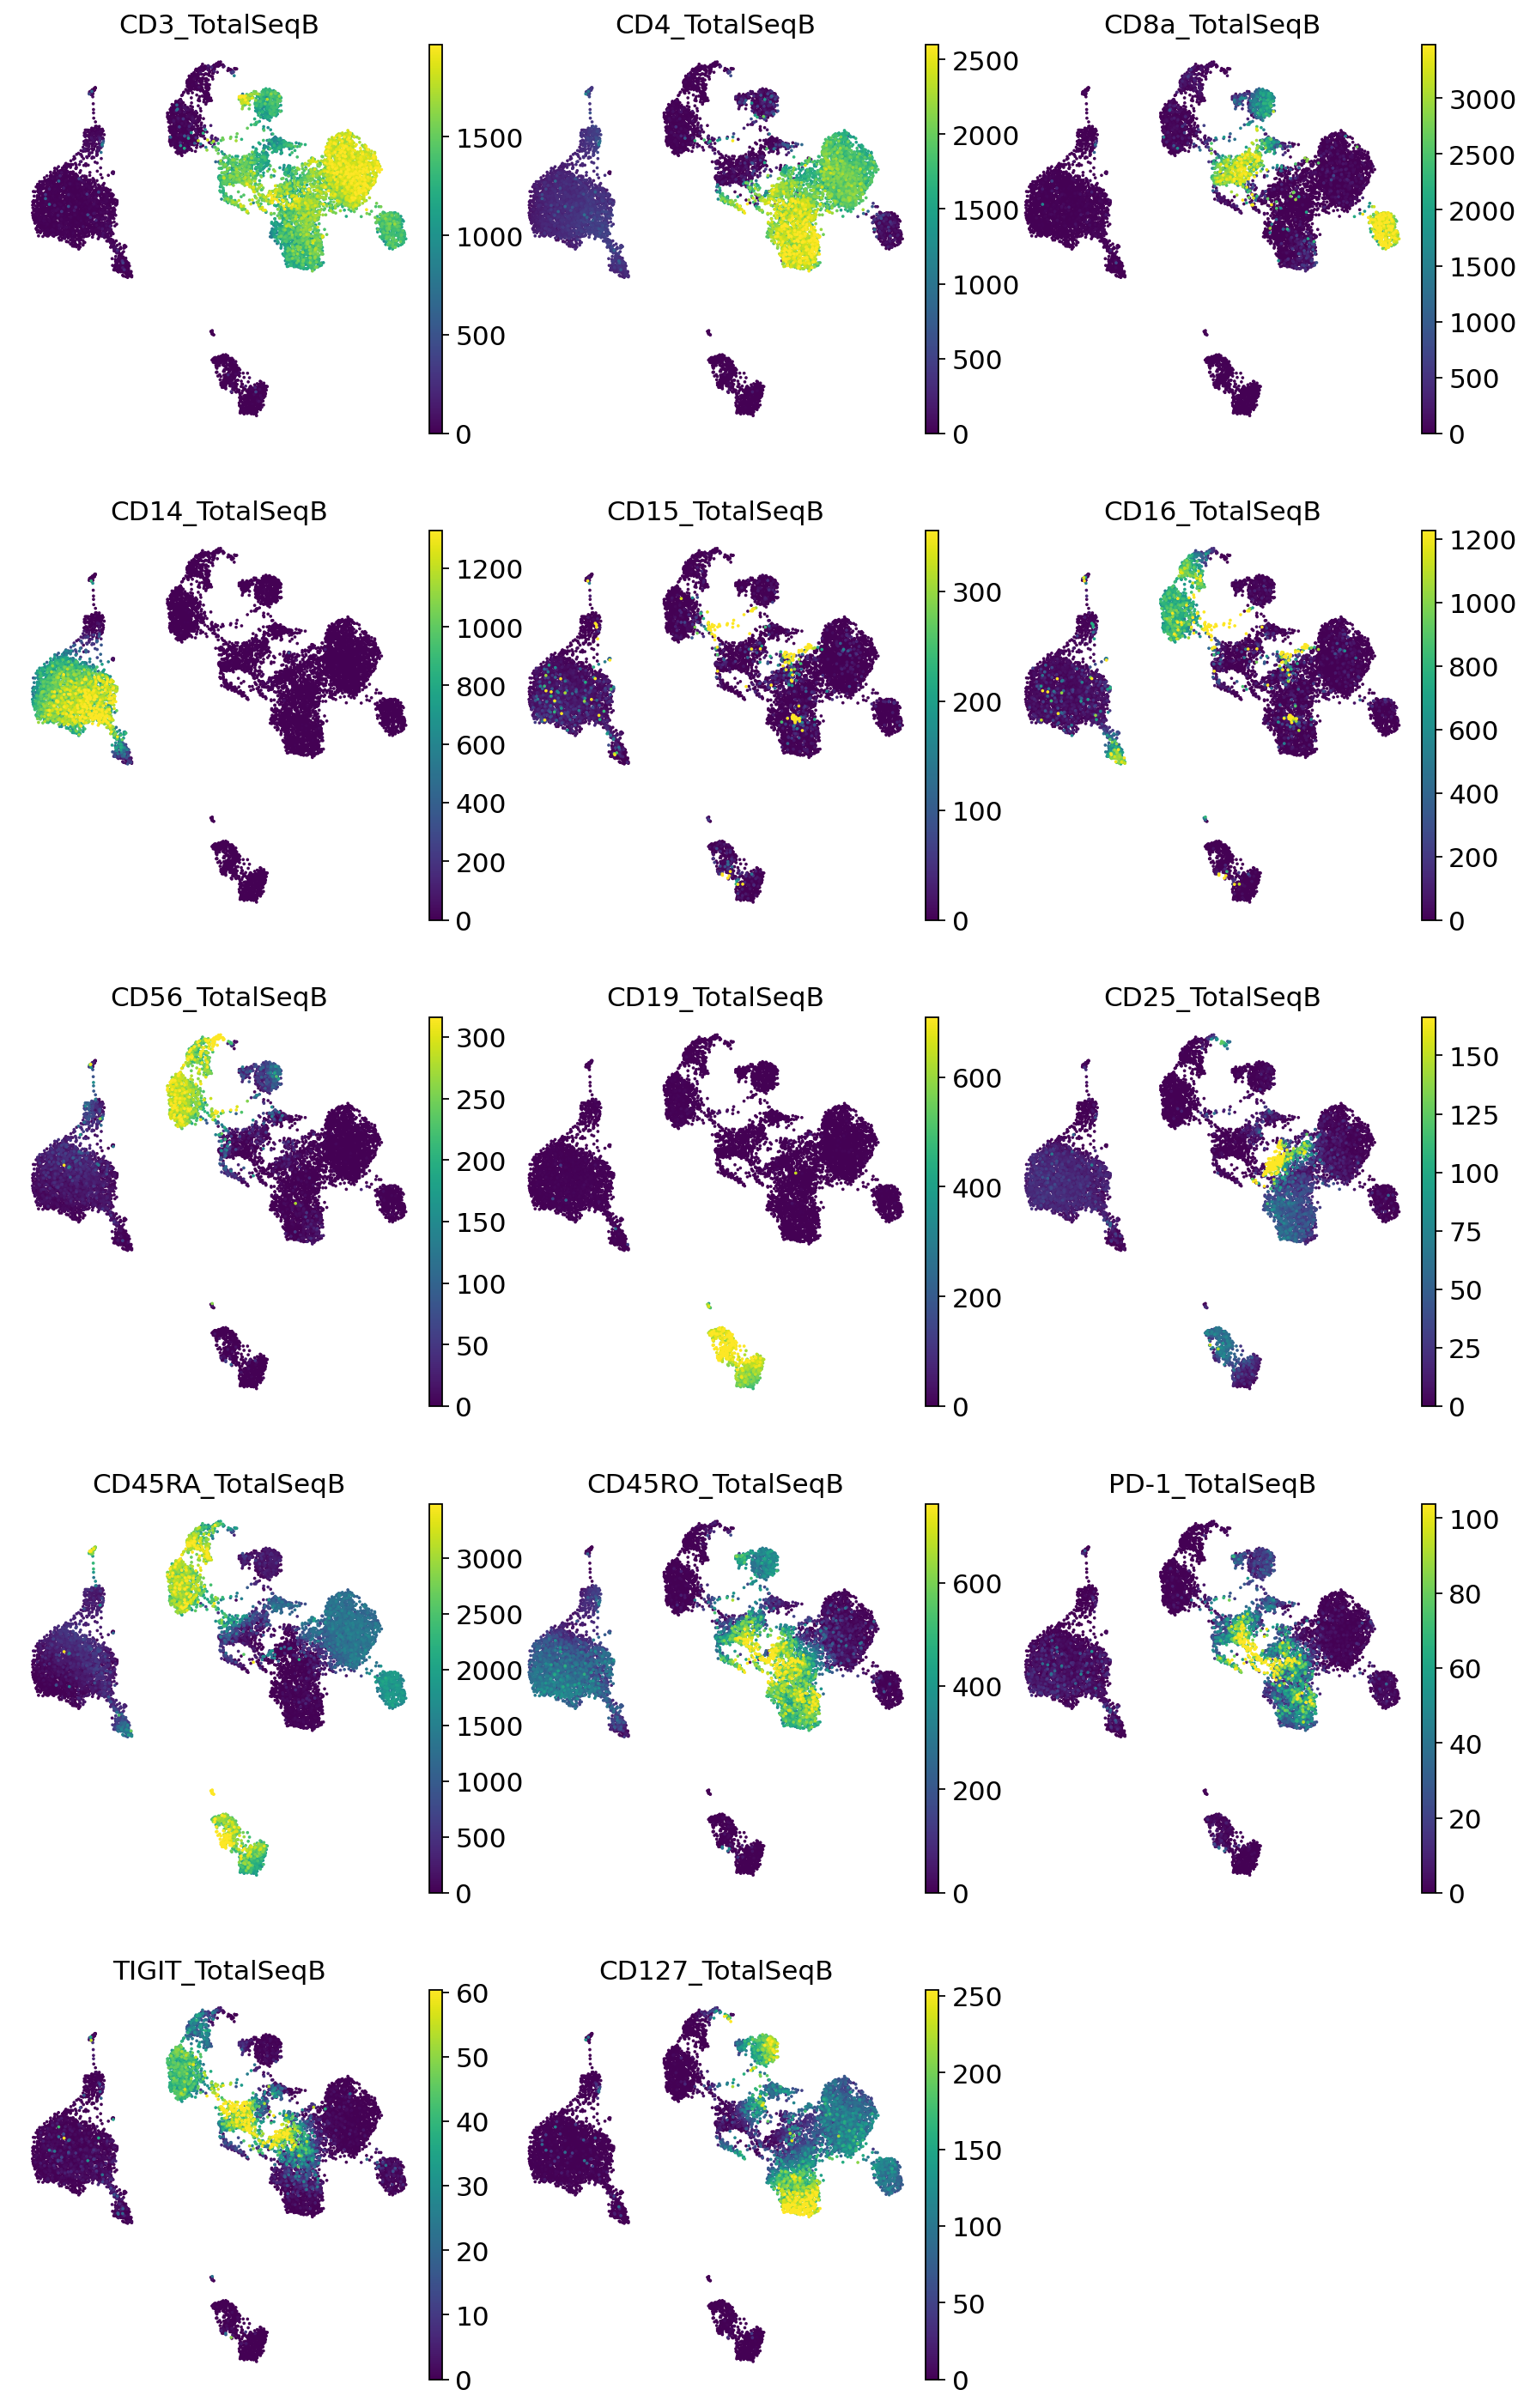

In [14]:
sc.pl.umap(
    pro_adata, 
    color=pro_adata.var_names,
    gene_symbols="protein_names",
    ncols=3, 
    vmax="p99",
    use_raw=False,
    frameon=False,
    wspace=0.1
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

<div class="alert alert-info">

Note

While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.

</div>

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

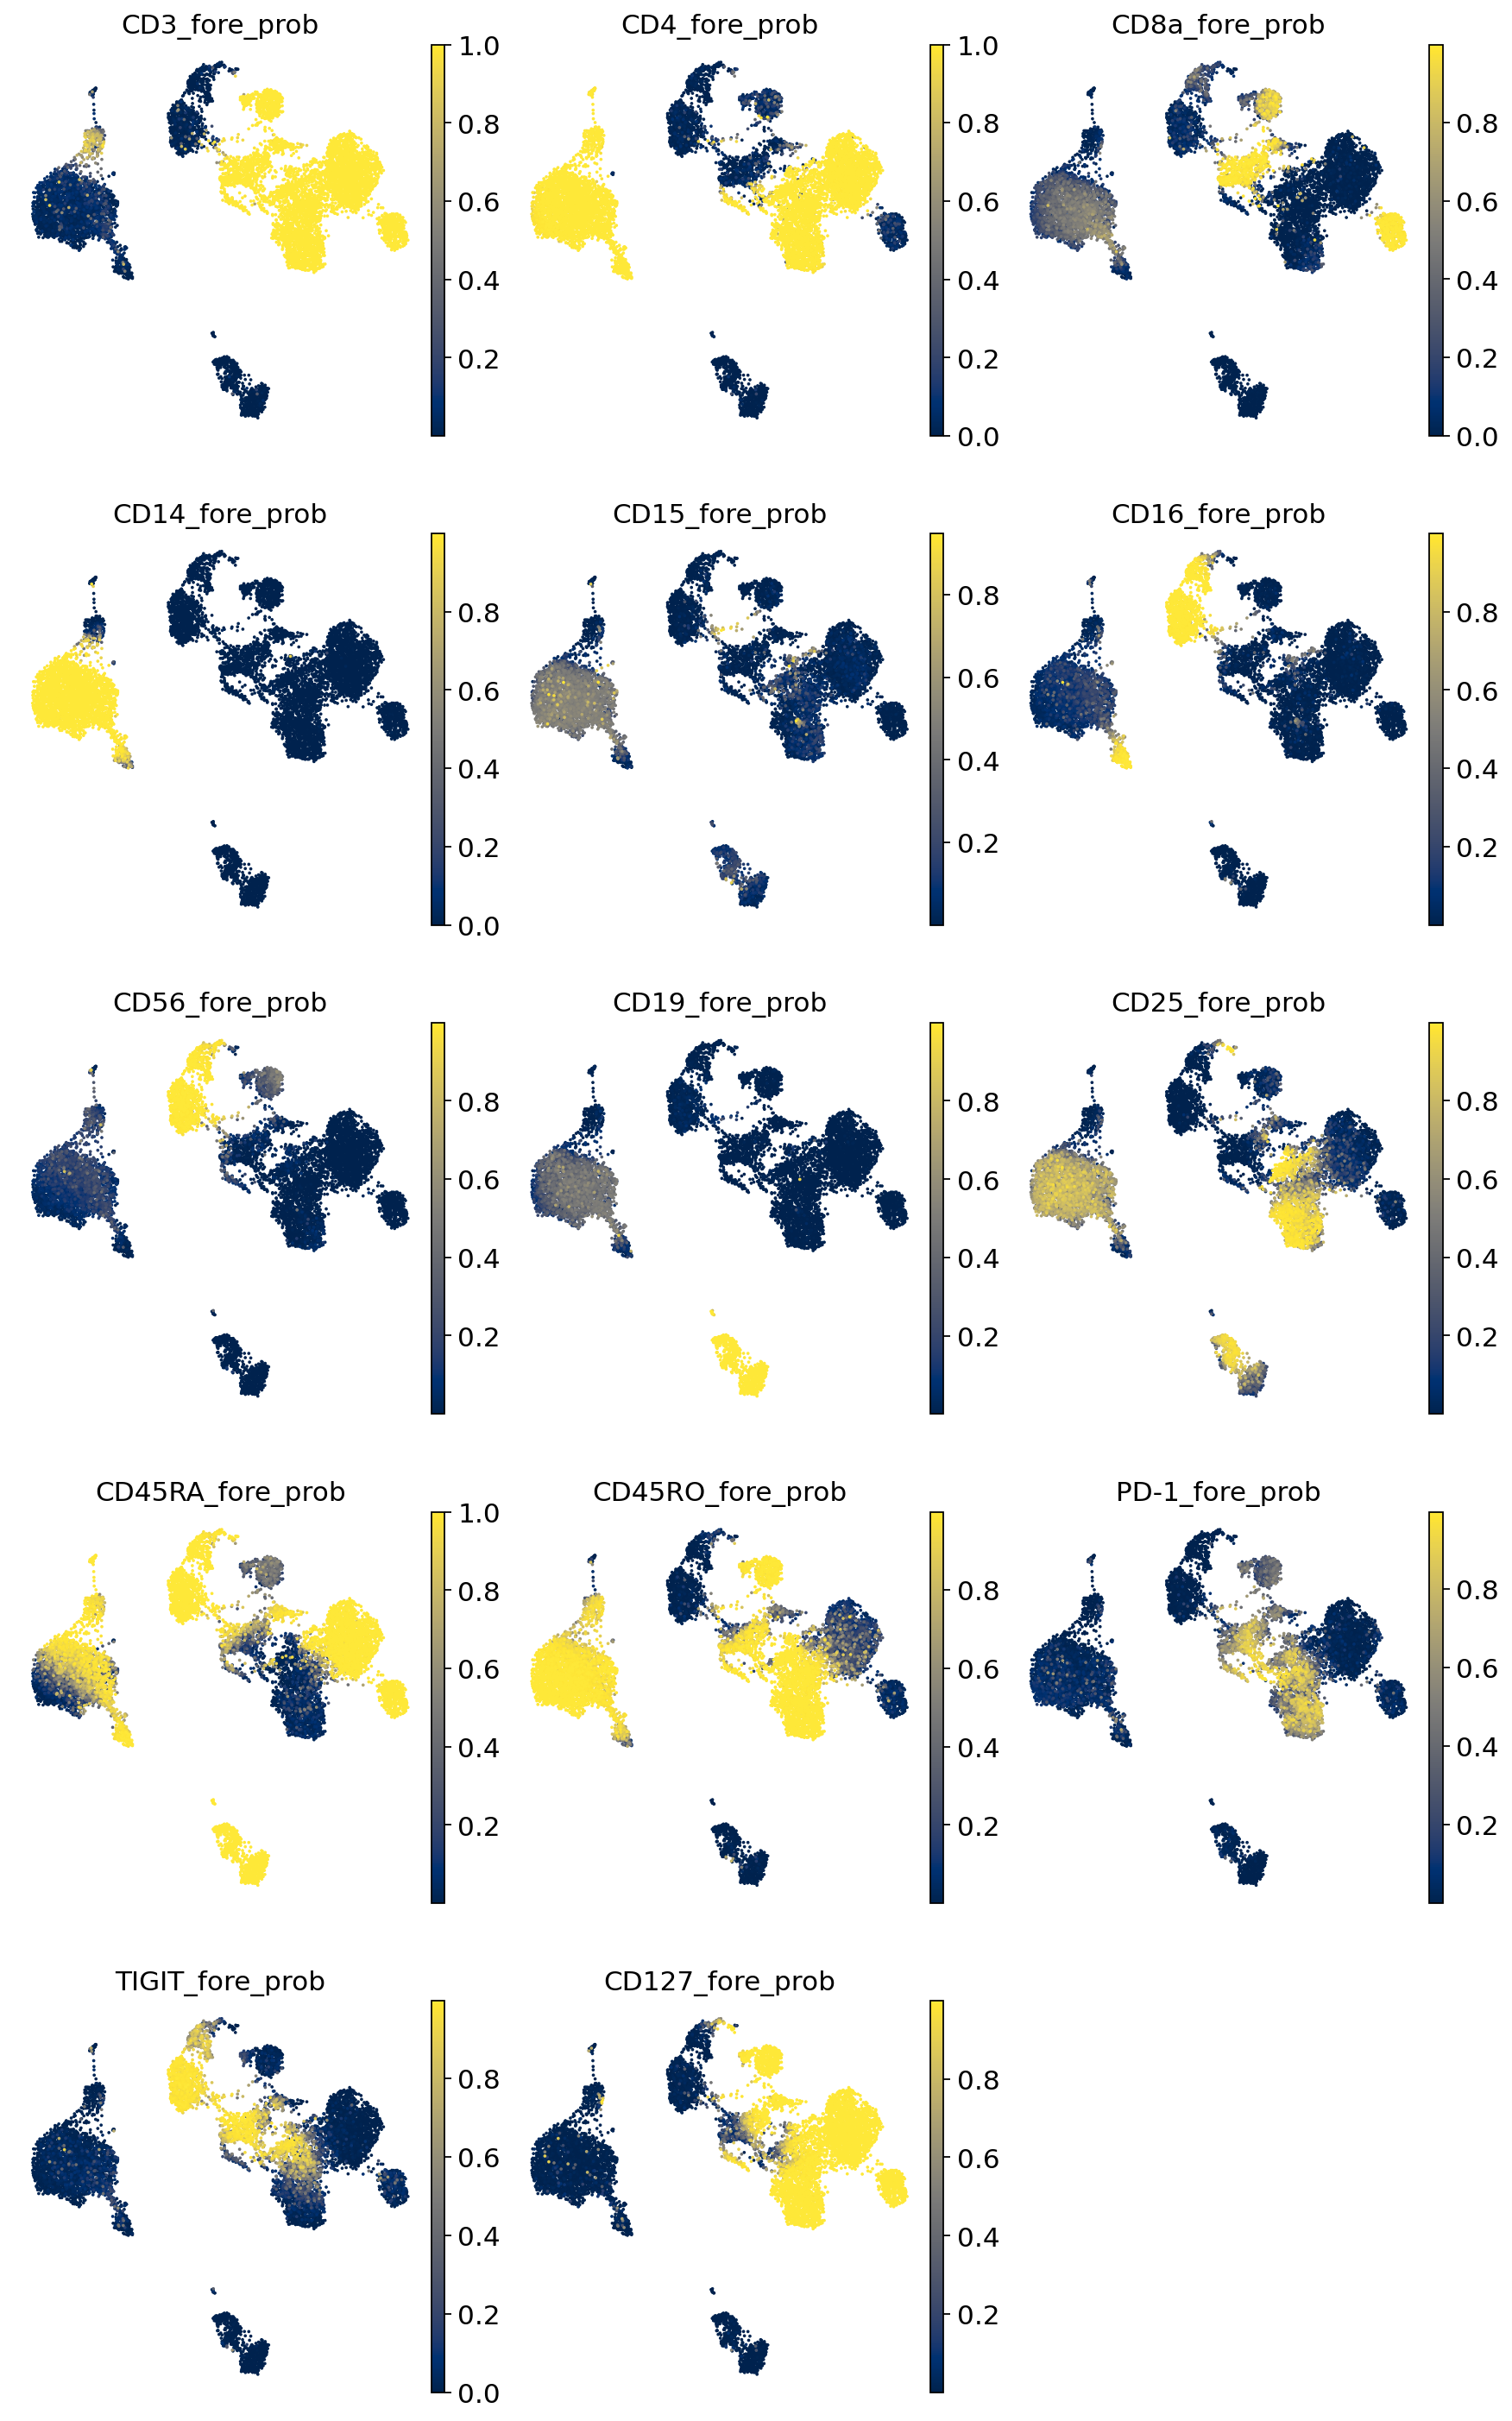

In [15]:
sc.pl.umap(
    pro_adata,
    color=["{}_fore_prob".format(p) for p in parsed_protein_names],
    ncols=3,
    color_map="cividis",
    frameon=False,
    wspace=0.1
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster. The results for each of the one-vs-all tests is concatenated into one DataFrame object. Inividual tests can be sliced using the "comparison" column. Genes and proteins are included in the same DataFrame.

<div class="alert alert-info">

Important

We do not recommend using totalVI denoised values in other differential expression tools, as denoised values are a summary of a random quantity. The totalVI DE test takes into account the full uncertainty of the denoised quantities.

</div>

In [16]:
de_df = vae.differential_expression(
        groupby="leiden_totalVI", 
        delta=0.5,
        batch_correction=True
)
de_df.head(5)

Output()

proba_de  proba_not_de  ...  raw_normalized_mean2  comparison
STEAP4       0.9914        0.0086  ...              0.030517   0 vs Rest
BPI          0.9910        0.0090  ...              0.006677   0 vs Rest
SERPINB10    0.9908        0.0092  ...              0.001893   0 vs Rest
PADI2        0.9900        0.0100  ...              0.029623   0 vs Rest
LGALS12      0.9896        0.0104  ...              0.010646   0 vs Rest

[5 rows x 17 columns]

Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [17]:
filtered_pro = {}
filtered_rna = {}
cats = adata.obs.leiden_totalVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains('TotalSeqB')
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

We can also use general scanpy visualization functions

In [18]:
sc.tl.dendrogram(adata, groupby="leiden_totalVI", use_rep="X_totalVI")
sc.tl.dendrogram(pro_adata, groupby="leiden_totalVI", use_rep="X_totalVI")

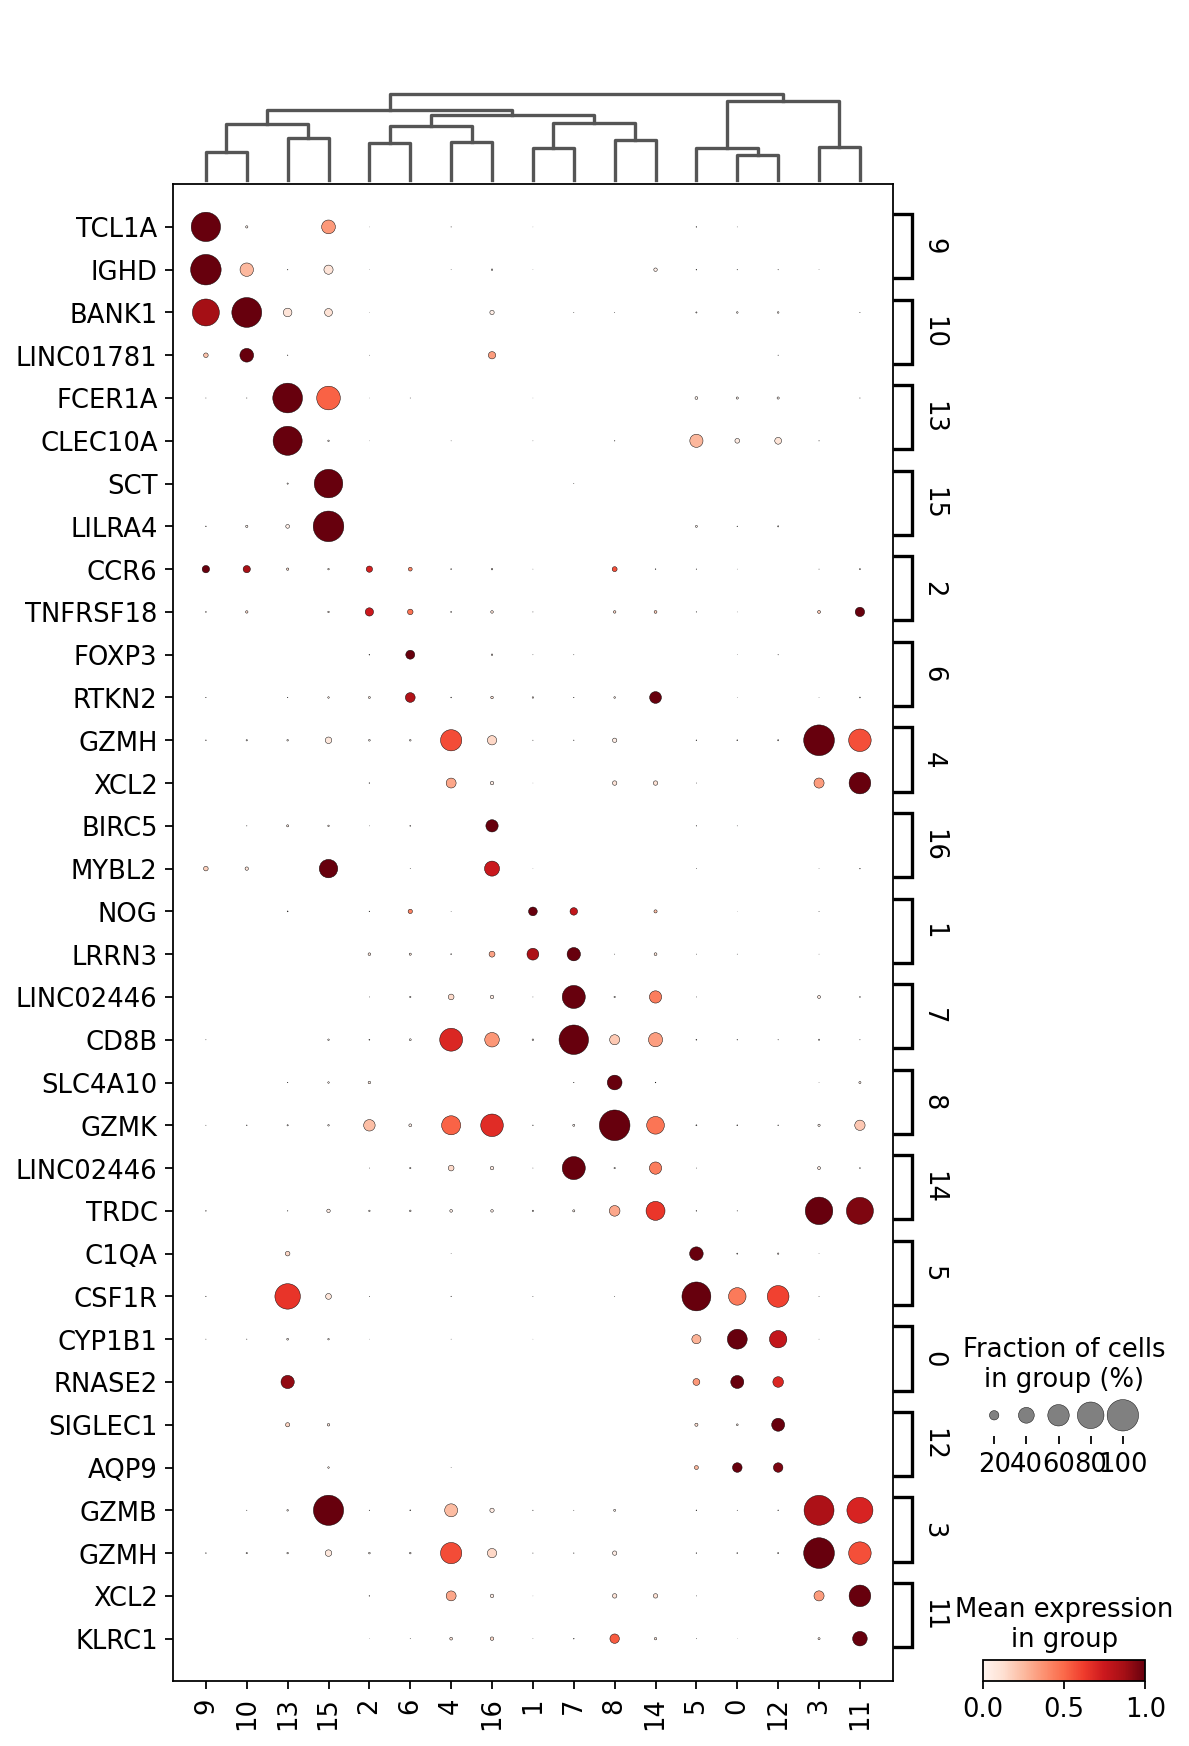

In [19]:
sc.pl.dotplot(
    adata, 
    filtered_rna, 
    groupby="leiden_totalVI", 
    dendrogram=True,
    standard_scale="var",
    swap_axes=True
)

Matrix plot displays totalVI denoised protein expression per leiden cluster.

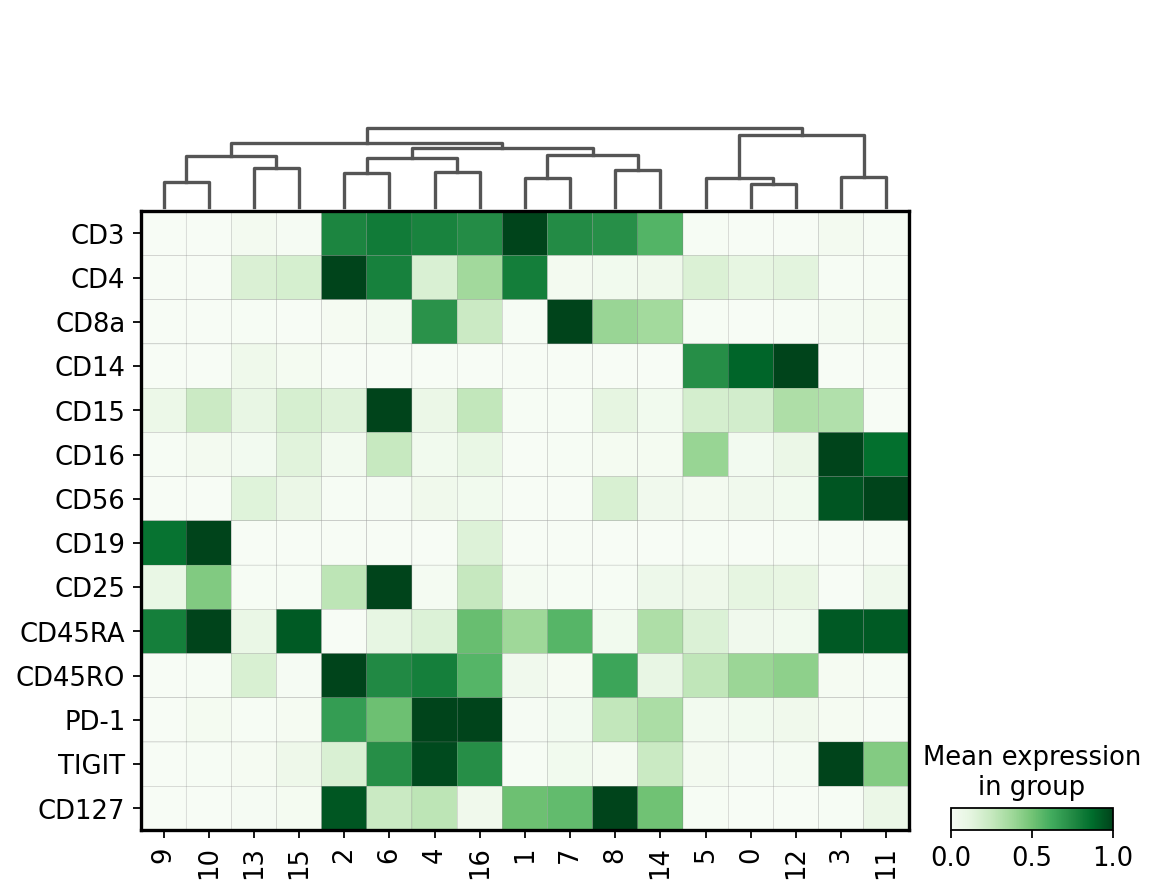

In [20]:
sc.pl.matrixplot(
    pro_adata,
    pro_adata.var["protein_names"],
    groupby="leiden_totalVI",
    gene_symbols="protein_names",
    dendrogram=True,
    swap_axes=True,
    use_raw=False, # use totalVI denoised
    cmap="Greens",
    standard_scale="var"
)

This is a selection of some of the markers that turned up in the RNA DE test. 

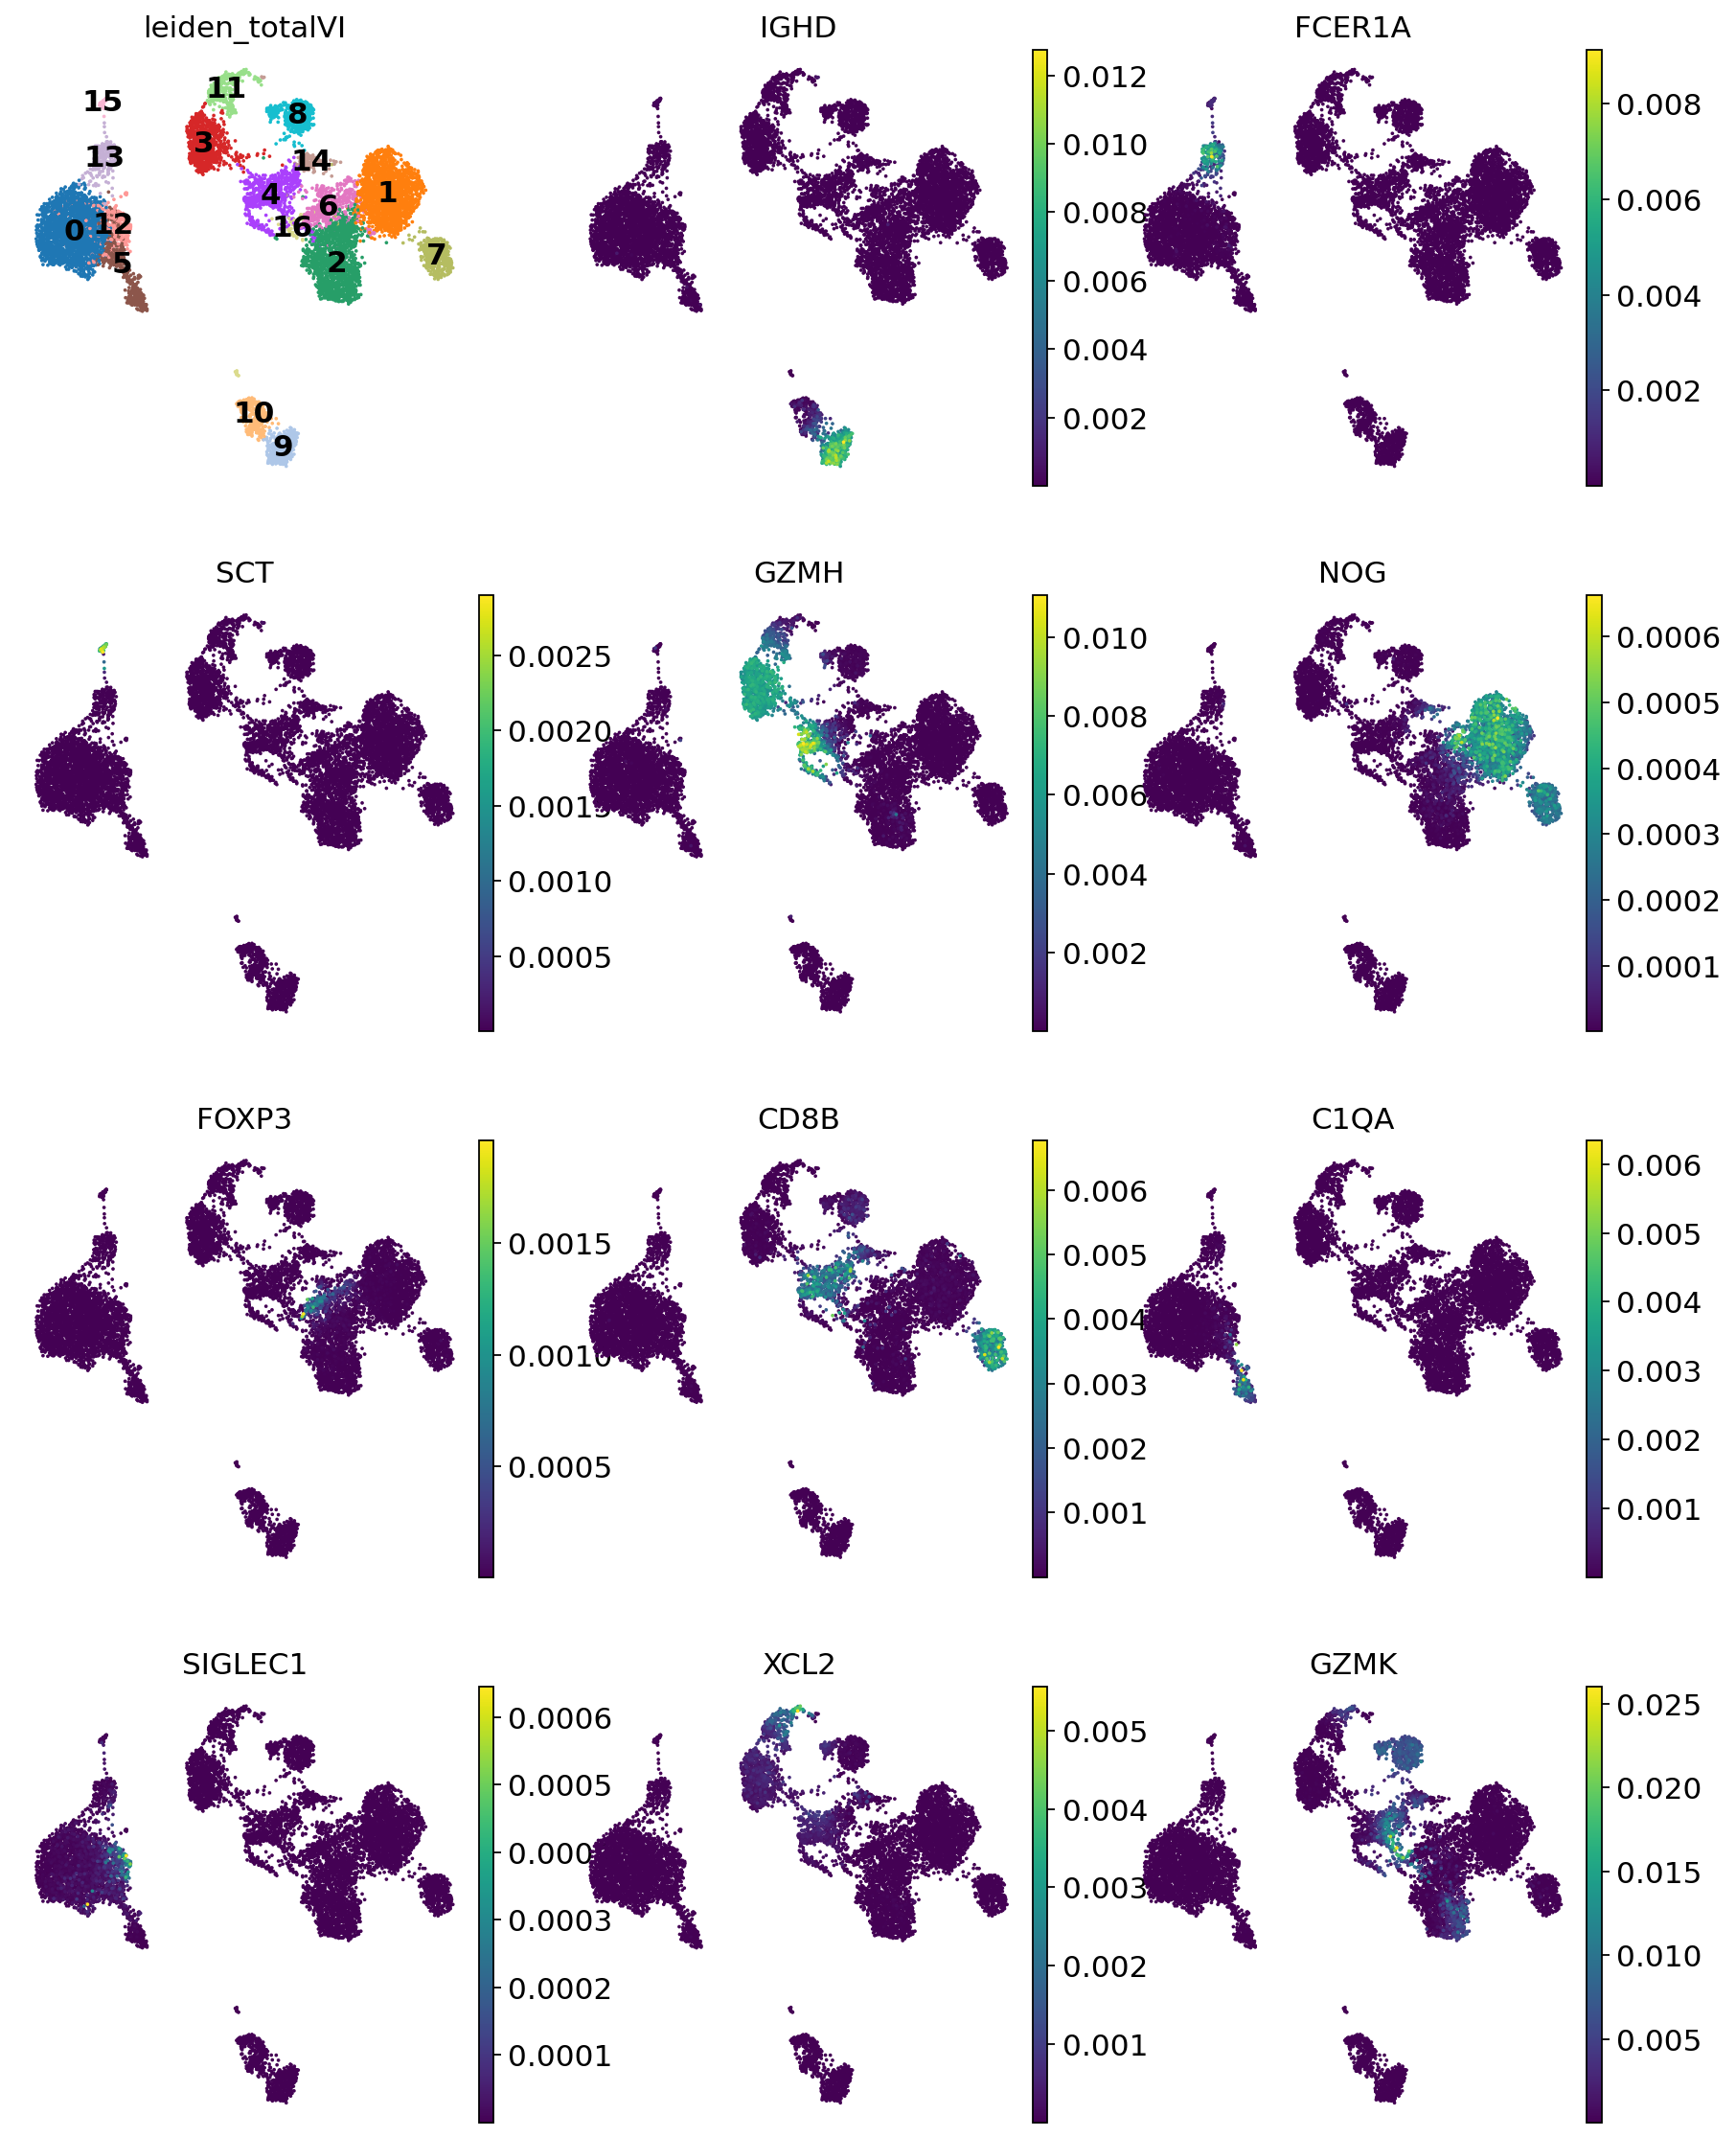

In [21]:
sc.pl.umap(
    adata, 
    color=[
           "leiden_totalVI", 
           "IGHD", 
           "FCER1A", 
           "SCT", 
           "GZMH", 
           "NOG", 
           "FOXP3", 
           "CD8B",
           "C1QA", 
           "SIGLEC1", 
           "XCL2", 
           "GZMK", 
           ], 
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.1
)